# Align PAO basis vectors with Hungarian algorithm

In [1]:
from glob import glob

import numpy as np
import matplotlib.pylab as plt
from numpy.linalg import norm
from scipy.optimize import linear_sum_assignment

from pao_utils import parse_pao_file, append_samples

In [2]:
raw = []
for fn in sorted(glob("2H2O_MD/frame_*/2H2O_pao44-1_0.pao")):
    kinds, atom2kind, coords, xblocks = parse_pao_file(fn)
    raw.append(xblocks[2]) # pick first Hydrogen atom
    
raw = np.array(raw)

# Raw PAO Coefficient Trajectories

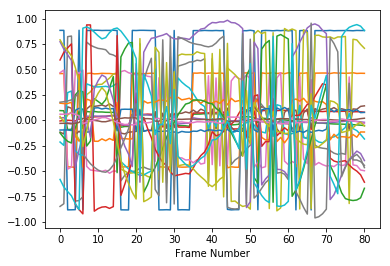

In [3]:
# raw data
for i in range(raw.shape[1]):
    for j in range(raw.shape[2]):
        plt.plot(raw[:,i,j])
plt.xlabel("Frame Number");

# Aligned PAO Coefficient Trajectories

In [4]:
def mirror(xblock):
    """ duplicate pao vectors with flipped sign """
    m, n = xblock.shape # size of pao and prim basis
    result = np.zeros((2*m, n))
    result[:m,:] = xblock
    result[m:,:] = -xblock
    return result

def align(xblock, ref_xblock):
    """ align xblock onto ref_xblock inplace """
    m, n = xblock.shape # size of pao and prim basis
    a = mirror(xblock)
    b = mirror(ref_xblock)
    dist = np.zeros((2*m,2*m))
    for i in range(2*m):
        for j in range(2*m):
            dist[i,j] = norm(a[i,:] - b[j,:])
    row_ind, col_ind = linear_sum_assignment(dist) # Hungarian algorithm
    score = dist[row_ind, col_ind].sum()
    #print(row_ind, col_ind, score)
    result = np.zeros((2*m,n))
    permutations = 0
    for i, j in zip(row_ind, col_ind):
        if i != j:
            permutations += 1
        result[i,:] = a[j,:]
    xblock[:,:] = result[:m,:]

    return permutations // 2 # number of permutations performed

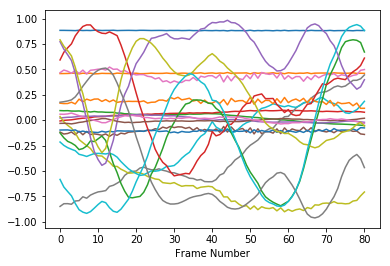

In [5]:
aligned = raw.copy()
for i in range(1, aligned.shape[0]):
    align(aligned[i], aligned[i-1])
    
for i in range(aligned.shape[1]):
    for j in range(aligned.shape[2]):
        plt.plot(aligned[:,i,j])
plt.xlabel("Frame Number");